# 1. Coordinates,  Grids and Fields

Hcipy is a Python library for high-contrat imaging simulations. It uses the concept of a ```Field``` to simplify sintax and avoid user error. The concept of ```Field``` and their corresponding ```Grid``` and ```Coords``` is an integral part of HCIPY and is used thoughout the codebase. This first chapter will focus on ways to create, modify and use Fields

First let's import HCIPy and a few supporting libraries

In [1]:
from hcipy import *

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

A ```Grid``` defines a set of points in space. There are many functions available for creating a ```Field``` from scratch. One of these is ```make_unifom_grid()```. This function creates a regularly-spaced grid of points in N-dimensions in Cartesian space. The following code creates a ```Grid``` and plots the set of points using Matplotlib

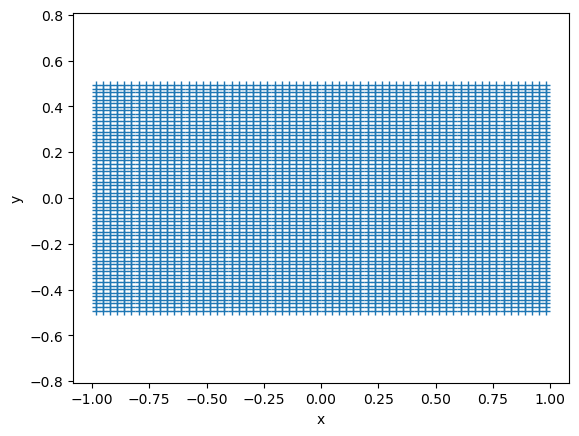

In [2]:
grid = make_uniform_grid([64,64], [2,1])

plt.plot(grid.x, grid.y, '+')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Depending on the coordinate system of the ```Grid```, it exposes the arguments x, y, z for Cartesian coordinates or r, theta for polar coordinates. The grid facilitates the conversion between an index and a point in N-dimensional space.

The coordinate values ofr each dimension are stored internally in a ```Coords``` object. There exist some variants of this type of object. Each of these derived classes indicates a struture in the coordinate values. For instance, in the case above>

In [3]:
print('Class of grid:', grid.coords.__class__)
print('Distance between points:', grid.delta)
print('Number of points on each dimension:', grid.dims)
print('Zero-point of the grid:', grid.zero)

Class of grid: <class 'hcipy.field.coordinates.RegularCoords'>
Distance between points: [0.03125  0.015625]
Number of points on each dimension: [64 64]
Zero-point of the grid: [-0.984375  -0.4921875]


A ```RegularCoords``` object doesn't store the values of eachpoint explicitly, but rather calculates those on the fly from three parameters:
1. The distance between points.
2. The number of points on each dimension
3. The zero point

Let's use another coordinate system, and differently structured coordinates. We explicitly show how a ```Grid``` is constructed.

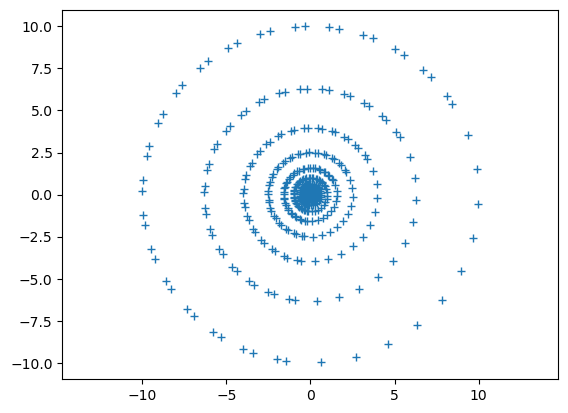

In [4]:
r = np.logspace(-1, 1, 11)
theta = np.linspace(0.2*np.pi, 11, endpoint=False)
coords = SeparatedCoords((r, theta))

polar_grid = PolarGrid(coords)
cart_grid = polar_grid.as_('cartesian')

plt.plot(cart_grid.x, cart_grid.y, '+')
plt.axis('equal')
plt.show()

Note that to plot the points of this polar grid, we have converte the polar grid to a Cartesian grid. Accessing the Cartesian coordinates on a polar grid is not allowed:

In [5]:
try:
    print(polar_grid.x)
except AttributeError as err:
    print(err)

'PolarGrid' object has no attribute 'x'


Each ```Grid``` also stores the weight of each point, that is, the interval, area, volume or hyper-volume that a point subtends in its space. The can be used to simplify doing integrations or taking derivatives on a ```Grid```. In some cases, the weights can be calculated automaticaly, for example when the grid has regular or separated coordinates. For other coordinate structures, the weights must be supplied by the user, for example for an UnstructuredCoords.

A ```Field``` is a sampled function on a Grid. The an be thought of as a physical ield, sampled on each point of a ```Grid```. We can simply construct a field by:

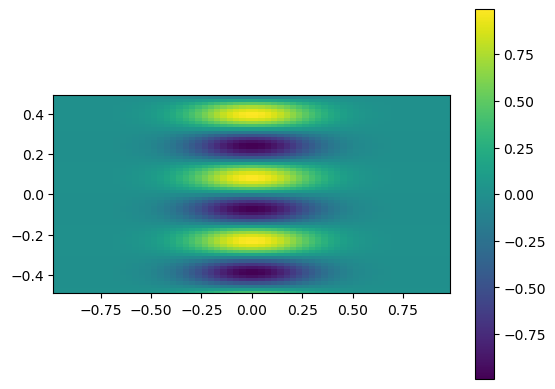

In [6]:
values = np.exp(-(grid.x**2 * 10)) * np.sin(20*grid.y)
field = Field(values, grid)

imshow_field(field)
plt.colorbar()
plt.show()

A field can be shown by using ```imshow_field()```, which acts very similar to the standard Matplotlib ```pyplot.imshow()``` function. It however does some thing in the background. The axes are set to the correct values, according to the ```Grid``` of the ```Field```. Additionally, it supports many other features. For instance, a complex valued field is automatically converted to a two-dimensional colorscale.

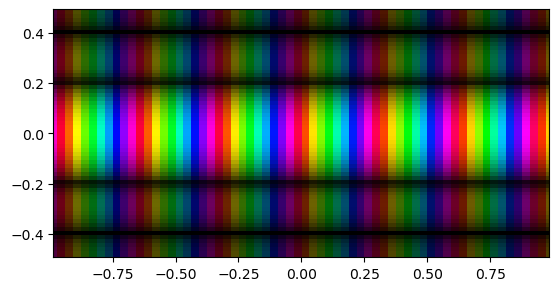

In [7]:
values2 = np.exp(1j * grid.x * 20) * np.sqrt(np.abs(np.sinc(5*grid.y)))
field2 = Field(values2, grid)

imshow_field(field2)
plt.show()

This images can be extremely useful for viewing both phase and amplitude of a coplex speckle field at the same time. Additionally, it supports masking out parts of the array during plotting:

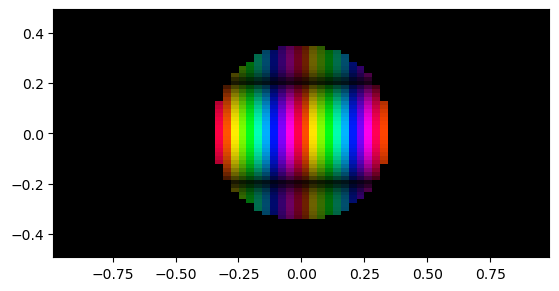

In [8]:
mask = make_circular_aperture(0.7)(grid)

imshow_field(field2, mask=mask)
plt.show()

This function ```make_circular_aperture(0.7)``` here constructs a so-called ```Field``` genertor. These are functions that take a grid as their sole parameter, and spit out a Field on that grid. Essentially, this can be used to calculate any analytical function at a set of points. Some classes and functions in HCIPy take ```Field``` generators as arguments, and they are used as output in some cases as well. An important class of ```Field``` generators are those generated by aperture unctions. These include the above mentioned circular_aperture, but also ```rectangular_aperture```, ```hexagon_aperture```, or even complete telescopes, such as ```make_magellan_perture```:

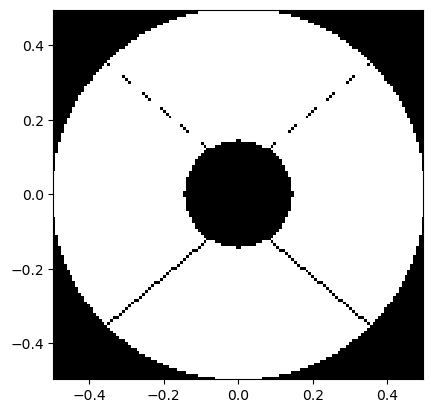

In [9]:
pupil_grid = make_pupil_grid(128)
aperture = make_magellan_aperture(True)

imshow_field(aperture(pupil_grid), cmap='gray')
plt.show()

As the spiders for the Magellan aperture are very small, we have some aliasing effets. This can be avoided using supersampling during the evaluation. HCIPy implements standard functions for these:

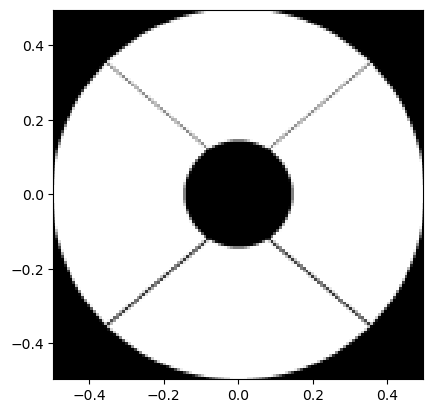

In [10]:
pupil = evaluate_supersampled(aperture, pupil_grid, 8)
imshow_field(pupil, cmap='gray')
plt.show()

# 2.Wavefronts and optical systems

Wavefronts in HCIPy are monochromatica. They consist ofan electric field (as an HCIP Field), and a wavelength. If broadband images are needed, multiple ```Wavefront```s must be constructed and propagated through the optical system, sampling the required wavelength range. Lete us construct a ```Wavefront```.

In [11]:
pupil_grid = make_pupil_grid(1024)
aperture = make_circular_aperture(1)(pupil_grid)

wavefront = Wavefront(aperture, 1)

A note must be made at this point regarding units. HCIPy is averse w.r.t. the used units. If the user fills in all quantitites in SI, then all calculations in HCIPy will be returned in SI units. This allows the user to use any unit he wants, while still being abel to seamlessly use dimensionless quantities. Ie. the convention that is used in this docuemnte, is that if the diameter of the aperture is 1, the wavelength is 1, and the focal length is 1 as well, the the focal-plane will be given in $\lambda$/D

To propagate this wavefront to the foal plane, we first need to construct a grid on which the focal plane will be sampled

In [12]:
focal_grid = make_focal_grid(8, 16)

This construcs a ```Grid``` with 8 samplers per $\lambda$/D and a 16 $\lambda$/D radius field of view. Now we can construct a Fraunhofer propagator that can actually propagate the lght to the focal plane

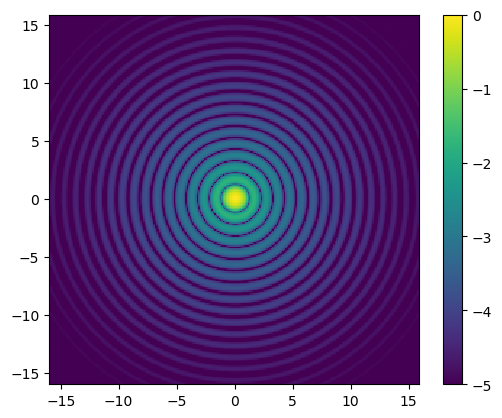

In [13]:
prop = FraunhoferPropagator(pupil_grid, focal_grid)

img = prop.forward(wavefront)

imshow_field(np.log10(img.intensity / img.intensity.max()), vmin=-5)
plt.colorbar()
plt.show()

All Fourier transforms concerning the propagation are done internally. In ths case a Matrix Fourier transform was used as it was deemed quicker than a Fast FOurier transform in this case. Alos note that when defiing the propagaor, we didn't pass the wavelength of the wavefront. This wavelength is taken form the Wavefront object durig the propagation

Also note that a ```Wavefront``` supports many properties to make it easier to use One that we used aboe is Wavefront.intensity, but othersexist as well: for example Wavefront.phase and ```Wavefront.amplitude```, which yield the phase and amplitude of the electric field respectively. All these properties are returned as ```Field```s and can therefore be shown using ```imshow_field()```

For a more interesting result, let's do a propagation with pyhsical quantities. We calculate the intensity pattern of a circular aperture with a diameter of 1cm, after a free-space propagation of 2m, at a wavelength of 500nm.

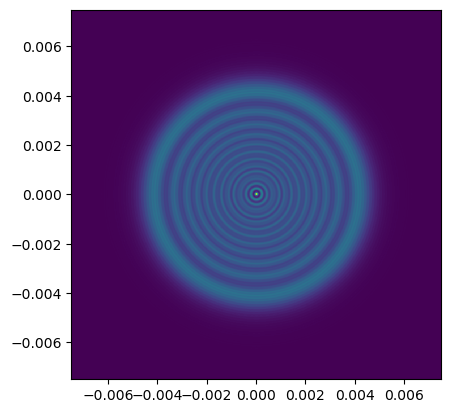

In [14]:
pupil_grid_2 = make_pupil_grid(1024, 0.015)
aperture_2 = make_circular_aperture(0.01)(pupil_grid_2)

fresnel_prop = FresnelPropagator(pupil_grid_2, 2)

wf = Wavefront(aperture_2, 500e-9)
img = fresnel_prop.forward(wf)

imshow_field(img.intensity)
plt.show()

The proagators shown previously are part of a larger group of optical elemetns. All ```OpticalElements``` can proagate a ```Wavefront``` through them. Examples include simple ```Apodizer```s, which act as an infinitel-thin screen with a (complex) transmission. A little more complicated example is ```SurfaceAberration```, which simulates a surface error with a power-law PSD (power spectral density). Optical elements can be linked to represent more complicated optical systems.

/home/dani/miniconda3/envs/sail-env/lib/python3.9/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


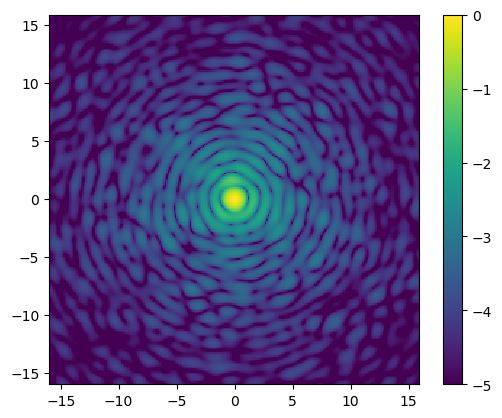

In [15]:
aberration = SurfaceAberration(pupil_grid, 0.25, 1)

wf = Wavefront(aperture)
img = prop(aberration(wf))

imshow_field(np.log10(img.intensity / img.intensity.max()), vmin=-5)
plt.colorbar()
plt.show()

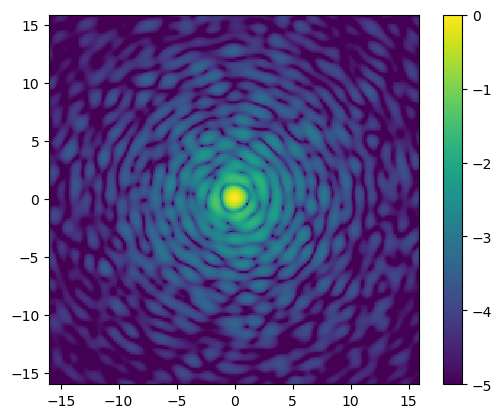

In [16]:
aberration = SurfaceAberration(pupil_grid, 0.25, 1)

wf = Wavefront(aperture)
img = prop(aberration(wf))

imshow_field(np.log10(img.intensity / img.intensity.max()), vmin=-5)
plt.colorbar()
plt.show()

These simple optical elements can be combined into more complicated optical systems. These include full wavefront sensor implementations and coronagraphs. Both of these will be handled in later sections.

To convert a ```Wavefront``` into an observed image, once can simply use the ```Wavefront.power``` attribute, which is the ```Wavefront.intensity``` multiplied by the weight at each pixel. If one wants to use a more complicated detector model, HCIPy supplies a ```Detector``` class, and its derivatives. A detector uses an integration/readout scheme

/tmp/ipykernel_59610/3883467574.py:11: RuntimeWarning: divide by zero encountered in log10
  imshow_field(np.log10(image), vmax=np.log10(image).max(), vmin=0)


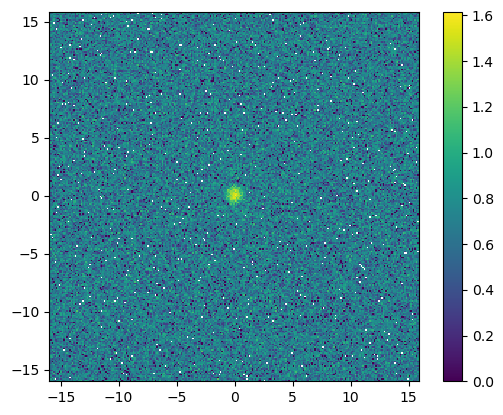

In [17]:
flat_field = 0.01
dark = 10
detector = NoisyDetector(focal_grid, dark_current_rate=dark, flat_field=flat_field)

wf.total_power = 5000
img = prop(aberration(wf))

detector.integrate(img, 0.5)
image = detector.read_out()

imshow_field(np.log10(image), vmax=np.log10(image).max(), vmin=0)
plt.colorbar()
plt.show()

# 3. Atmosphere and adaptive optics

HCIPy implements a multi-layer atmospheric model. Each layer derives from tmosphericLayer. This allows for multiple implementations of phase-screen calculation. One of the implemented methods is an infinite phase-screen extrusion method by ssemat et al. 2006. We first do some setup work.

In [18]:
D_tel = 8.2
wavelength = 1e-6

pupil_grid = make_pupil_grid(512, D_tel)
focal_grid = make_focal_grid(8, 16)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

aperture = circular_aperture(D_tel)(pupil_grid)

/tmp/ipykernel_59610/3470006355.py:8: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  aperture = circular_aperture(D_tel)(pupil_grid)


We can now construct the layer

In [19]:
fried_parameter = 0.2 # meter
outer_scale = 20 # meter
velocity = 10 # meter/sec

Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

For each layer, its strength ($C^2_n$ value), outer scale ($L_0$) and velocity can be changed. The InfiniteAtmosphericLaer class even supports on-the-fly changes to these values, allowing for non-stationary turbulence simulations. We can retrieve teh phase at a certai wavelength as:

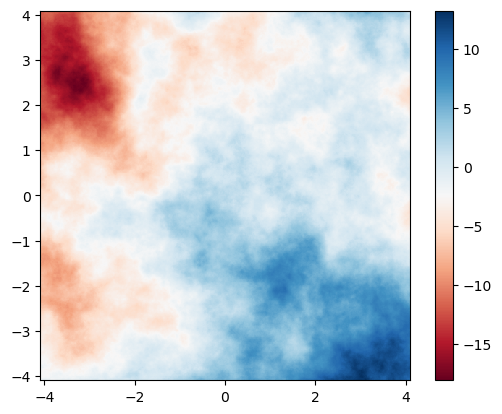

In [20]:
imshow_field(layer.phase_for(wavelength), cmap='RdBu')
plt.colorbar()
plt.show()

And we can propagate light through the atmospheric layer as usual.

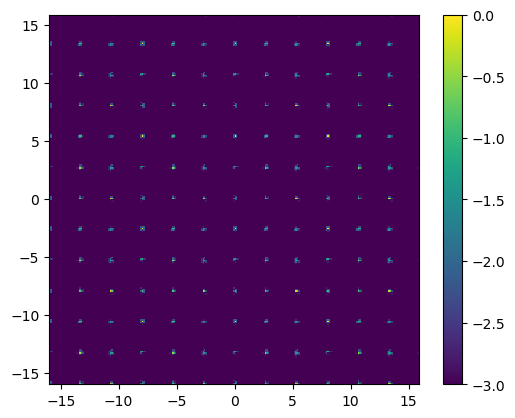

In [23]:
layer.t = 0.1 # sec

img = prop(layer(wf))

imshow_field(np.log10(img.intensity / img.intensity.max()), vmin=-3)
plt.colorbar()
plt.show()

These sinle layers can be combined into a multi-layer atmoshperic model. Here we standard atmospheric model. Here we have a standard atmospheric model. Any layer structure can be implemented. The altitude of each layer is indicated by the height parameter of the AtmosphericLayer objects themselves.

As we want to do Fresnel diffraction and avoid edge effects, we have to redefine our grids to be slightly oversized. Afterwards we make the atmospheric layers, and add the to a multi-layer atmospheric model.

In [24]:
pupil_grid = make_pupil_grid(256, 1.5)
focal_grid = make_focal_grid(2, 64)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

pup = make_circular_aperture(1)(pupil_grid)

# Make multi-layer atmosphere
layers = make_standard_atmospheric_layers(pupil_grid, outer_scale)

atmos = MultiLayerAtmosphere(layers, scintillation=True)

Now we can set the right seeing parameter and propagate through it to show the scintillation. To avoid edge efects during the Fresnel propagation, we use a super-Gaussian as an amplitude mask. This makes the edges of the field more continous and therefore lessens edge effects.

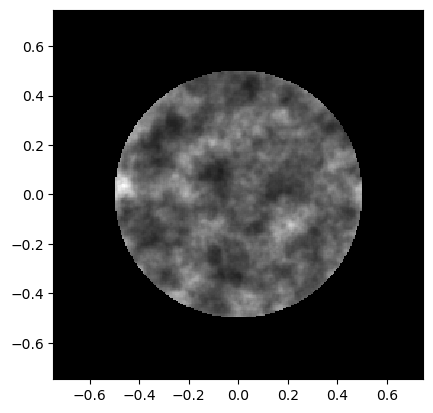

In [25]:
# Set the seeing parameters and reset
atmos.Cn_squared = Cn_squared_from_fried_parameter(0.1, 550e-9)
atmos.reset()

# Use super-Gaussian to avoid edge effects
p = np.exp(-(pupil_grid.as_('polar').r/0.68)**20)
wf = atmos(Wavefront(Field(p, pupil_grid), 2e-6))

# Show scintillation field
imshow_field(wf.intensity * pup, cmap='gray')
plt.show()

In [ ]:
import hcipy
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
telescope_diameter = 4.0  # meters
wavelength = 0.6e-6  # meters (wavelength of light)
grid_size = 256  # size of the simulation grid
r0 = 0.2  # Fried parameter in meters

# Create aperture and wavefront
aperture = hcipy.CircularAperture(telescope_diameter)
telescope = hcipy.OpticalSystem([hcipy.CompoundApodizer([aperture])])
wavefront = hcipy.Wavefront(hcipy.Field(np.zeros((grid_size, grid_size)), aperture.grid))

# Generate atmospheric turbulence
turbulence = hcipy.AtmosphericTurbulence(telescope, r0)
wf_after_turbulence = turbulence(wavefront)

# Visualize Results
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
hcipy.imshow_field(wavefront.phase, cmap='RdBu', extent=wavefront.grid.extent)
plt.title('Original Wavefront')

plt.subplot(1, 2, 2)
hcipy.imshow_field(wf_after_turbulence.phase, cmap='RdBu', extent=wf_after_turbulence.grid.extent)
plt.title('Wavefront After Turbulence')

plt.show()